![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Analysis of Projected versus Historical Climatology with CORDEX Data

This notebook is a practical introduction to [CORDEX regional climate model data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=overview). CORDEX (Coordinated Regional Climate Downscaling Experiment) data are available for 14 regional domains and variable spatial resolutions, from 0.11 x 0.11 degrees up to 0.44 x 0.44 degrees. This workflow will demonstrate how to compute the difference in the air temperature climatology for 2071-2100 (according to a projected scenario) relative to the reference period 1971-2000 in Africa, with a spatial resolution of 0.44 x 0.44 degrees. 

We will use the historical experiment to **compute the past climatology** and repeat the steps to **compute the projected climatology** according to the scenario RCP4.5. Finally, we will take the difference between the two in order to **assess the extent of change**. This is called the "delta method" which takes the climate change signal as the difference between the future and past considering that the model biases are the same and can therefore be removed with the subtraction.

This particular example uses data from the Canadian Regional Climate Model `CCCma_CanRCM4`, with lateral boundary conditions from the Global Climate Model (GCM) `CanESM2`, also Canadian. This coupled model is referred to as `CanRCM4 - CanESM2`. See [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-DrivingGlobalClimateModelsandRegionalClimateModels) a full list of models included in the CDS-CORDEX subset.

<div class="alert alert-block alert-success">
    <b>NOTE</b>: </br>
    The workflow uses a specific model, scenario and geographical area, but you can use any model, scenario or domain, and indeed any period or variable. To have a more accurate idea of projected climate change, it is typical to calculate an ensemble of multiple models. Only for the sake of simplicity do we focus on one model.</div>

In general, CORDEX experiments can be divided into three main categories:

* **Evaluation**: model simulations for the past with imposed "perfect" lateral boundary conditions following ERA-Interim reanalysis (1979-2015).

* **Historical**: Historical experiments cover the period where modern climate observations exist. These experiements show how the RCMs perform for the past climate when forced by the Global Circulation Model (GCM) and can be used as a reference period for comparison with scenario runs for the future. 

* **Scenario experiments RCP2.6, RCP4.5, RCP8.5**: ensemble of CORDEX climate projection experiments driven by boundary conditions from GCMs using RCP (Representative Concentration Pathways) forcing scenarios. The scenarios used here are RCP 2.6, 4.5 and 8.5, which provide different pathways of the future climate forcing.

Learn [here](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#CORDEX:Regionalclimateprojections-Experiments) more about CORDEX experiments in the Copernicus Climate Data Store (CDS).

<hr>

## Learning objectives 🧠

1. Learn to compute a past climatology based on a historical experiment.

2. Learn to compute a projected climatology based on a scenario.

3. Understand what is the "delta method" and learning to analyse the difference between past and projected climatologies.



<hr>

## Target audience 🎯

**Anyone** interested in learning how to compute past and projected climatologies and to analyse differences between them.

<hr>

## Prerequisites and assumed knowledge 🔍
1. **Programming Skills**: Familiarity with programming concepts, particularly in Python, as the tutorial involves using loops, defining functions and using multiple different libraries for data manipulation and visualization.
   
2. **Familiarity with API Usage**: Understanding of how to use Application Programming Interfaces (APIs) will be useful for accessing data through the CDS API.

3. **Familiarity with multidimensional data structure**: Comprehending what are data dimensions and how they are organized in an array.


<hr>

:::{admonition} Difficulty
:class: tip
2/5
:::

<hr>

:::{dropdown} Run the tutorial
:open:
### WEKEO

[WEkEO](https://www.wekeo.eu/) serves as the official platform of the European Centre for Medium-Range Weather Forecasts (ECMWF), offering access to an extensive array of climate data and tools for analysis and visualization. It provides a robust environment for conducting in-depth analysis and exploration of climate-related datasets. To learn more about WEkEO and its offerings, visit their [website](https://www.wekeo.eu/).

[Run this notebook on WEKEO](https://www.wekeo.eu/) 

### Possible Cloud Services

While Kaggle, Binder, and Colab are popular options for running notebooks in the cloud, it's essential to note that these are just a few among many available choices. Each platform has its unique features and capabilities, catering to diverse user needs and preferences.



| **Kaggle** | **Binder** | **Colab** |
|:----------:|:---------:|:--------:|
| [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Randbee/projections-cordex/blob/master/projections-cordex.ipynb) | [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/Randbee/projections-cordex/master?labpath=projections-cordex.ipynb) | [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Randbee/projections-cordex/blob/master/projections-cordex.ipynb) |
:::

<hr>

## Outline

1. Import the necessary libraries
2. Access data with the CDS API
3. Unzip the downloaded data files
4. Compute CORDEX historical climatology for reference period 1971-2000
5. Compute CORDEX projected climatology for target period 2071-2100 based on scenario RCP4.5
6. Compute and visualize the climate change signal

<hr>

## 1. Import the necessary libraries

For downloading the data from the CDS we will need [cdsapi](https://pypi.org/project/cdsapi/). We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular [xarray](https://docs.xarray.dev/en/stable/), and [pandas](https://pandas.pydata.org/) to work with dataframes. We will also need libraries for plotting and viewing data, in this case we will use [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/).
If you don't have any of the following libraries, you must install it. You can do it like this:

In [1]:
!pip install cdsapi

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    Note the exclamation mark in the line of code above. This means the code will run as a shell (as opposed to a notebook) command.</div>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    If you are having trouble to work with the xarray library, check the C3S tutorial on climatologies for detailed help.</div>

In [1]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Other libraries (e.g. paths, filenames, zipfile extraction)
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile
import urllib3 
urllib3.disable_warnings() # Disable "InsecureRequestWarning" 
                           # for data download via API

<hr>

## 2. Access data with the CDS API

To access data from the CDS, you will need first to [register](https://cds.climate.copernicus.eu/#!/home) at the ADS registration page (if you haven't already done so), [log in](https://cds.climate.copernicus.eu/user/login), and accept the Terms and Conditions at the end of the `Download data` tab.<br>

To obtain data programmatically from the CDS, you will need an API Key that can be found in the [api-how-to page](https://cds.climate.copernicus.eu/api-how-to). Here your key will appear automatically in the black window, assuming you have already registered and logged into the ADS. Your API key is the entire string of characters that appears after `key:`

Now copy your API key into the code cell below, replacing `#######` with your key.

In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##########'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [2]:
DATADIR = './'

The next step is then to request the data with the help of the CDS API. We will download daily aggregated 2m air temperature with the following specifications:
- **Data**:
    - `CORDEX regional climate model data on single levels - Experiment: Historical`
    - `CORDEX regional climate model data on single levels - Experiment: RCP4.5`
- **Temporal coverage**: `1 Jan 1971 to 31 Dec 2000`
- **Spatial coverage**: `Domain: Africa`
- **Format**: `NetCDF in zip archives`

Below are two blocks of code for the both data requests:

In [6]:
c = cdsapi.Client(url=URL, key=KEY)

c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'africa',
        'experiment': 'historical',
        'horizontal_resolution': '0_44_degree_x_0_44_degree',
        'temporal_resolution': 'daily_mean',
        'variable': '2m_air_temperature',
        'gcm_model': 'cccma_canesm2',
        'rcm_model': 'cccma_canrcm4',
        'ensemble_member': 'r1i1p1',
        'start_year': ['1971', '1976', '1981', '1986', '1991', '1996'],
        'end_year': ['1975', '1980', '1985', '1990', '1995', '2000'],
    },
    f'{DATADIR}1971-2000_cordex_historical_africa.zip')

2024-06-28 11:12:43,242 INFO Welcome to the CDS
2024-06-28 11:12:43,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-06-28 11:12:43,643 INFO Request is queued
2024-06-28 11:12:44,698 INFO Request is running
2024-06-28 11:17:01,980 INFO Request is completed
2024-06-28 11:17:01,981 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data7/dataset-projections-cordex-domains-single-levels-1ee483bd-cf9e-4b2b-8447-e3a45f07ff30.zip to ./1971-2000_cordex_historical_africa.zip (908.2M)
2024-06-28 11:19:36,844 INFO Download rate 5.9M/s                                                                      


Result(content_length=952308195,content_type=application/zip,location=https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data7/dataset-projections-cordex-domains-single-levels-1ee483bd-cf9e-4b2b-8447-e3a45f07ff30.zip)

In [7]:
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'africa',
        'experiment': 'rcp_4_5',
        'horizontal_resolution': '0_44_degree_x_0_44_degree',
        'temporal_resolution': 'daily_mean',
        'variable': '2m_air_temperature',
        'gcm_model': 'cccma_canesm2',
        'rcm_model': 'cccma_canrcm4',
        'ensemble_member': 'r1i1p1',
        'start_year': ['2071', '2076', '2081', '2086', '2091', '2096'],
        'end_year': ['2075', '2080', '2085', '2090', '2095', '2100'],
    },
    f'{DATADIR}2071-2100_cordex_rcp_4_5_africa.zip')

2024-06-28 11:26:58,395 INFO Welcome to the CDS
2024-06-28 11:26:58,397 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-06-28 11:26:58,931 INFO Request is queued
2024-06-28 11:26:59,987 INFO Request is running
2024-06-28 11:31:17,249 INFO Request is completed
2024-06-28 11:31:17,251 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data4/dataset-projections-cordex-domains-single-levels-9b1336e5-deb3-4a5b-a1d0-3ab158fcd1b2.zip to ./2071-2100_cordex_rcp_4_5_africa.zip (908.1M)
2024-06-28 11:34:58,565 INFO Download rate 4.1M/s                                                                      


Result(content_length=952229444,content_type=application/zip,location=https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data4/dataset-projections-cordex-domains-single-levels-9b1336e5-deb3-4a5b-a1d0-3ab158fcd1b2.zip)

<hr>

## 3. Unzip the downloaded data files

From the CDS, CORDEX data are available in `NetCDF` format in compressed archives, either `zip` or `tar.gz`. For this reason, before we can load any data, we have to unzip or untar the files. Having downloaded the two experiments `historical` and `RCP4.5` as seperate zip files, we can use the functions from the `zipfile` Python package to extract the content of a zip file. First, we construct a `ZipFile()` object and second, we apply the function `extractall()` to extract the content of the zip file.

Below, the same process is repeated for the two zip files downloaded. We see that the actual data files are disseminated in `NetCDF`. CORDEX files are generally organised in five year periods. For this reason, for each zip file, six `NetCDF` files in five year periods are extracted.

In [3]:
cordex_zip_paths = glob(f'{DATADIR}*.zip')

In [4]:
for j in cordex_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

<hr>

## 4. Compute CORDEX historical climatology for reference period 1971-2000

The first step is to load the data of the `historical` experiment.

We can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_mfdataset` to read and concatenate multiple NetCDF files at once.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `rlat`, `rlon`, `time`, of which the dimension `bnds` is not callable.

In [5]:
ds_1971_2000_historical = xr.open_mfdataset(f'{DATADIR}*CanESM2_historical*.nc')
ds_1971_2000_historical

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 10950, rlat: 201, rlon: 194, bnds: 2)
Coordinates:
  * time          (time) object 88kB 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon          (rlon) float64 2kB -24.64 -24.2 -23.76 ... 59.4 59.84 60.28
  * rlat          (rlat) float64 2kB -45.76 -45.32 -44.88 ... 41.36 41.8 42.24
    lon           (rlat, rlon) float64 312kB dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat           (rlat, rlon) float64 312kB dask.array<chunksize=(201, 194), meta=np.ndarray>
    height        float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    rotated_pole  (time) |S1 11kB b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 2GB dask.array<chunksize=(1, 201, 194), meta=np.ndarray>
    time_bnds     (time, bnds) object 175kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    contact:                        cccma_info@ec.gc.ca
    Conventions:                    CF-1.4
    experiment:                     Historical run driven by CCCma-CanESM2
    ...                             ...
    history:                        created: 2012-06-29 23:52:08 by rcm2nc
    data_licence:                   1) GRANT OF LICENCE - The Government of C...
    creation_date:                  2012-06-29-T23:47:03Z
    c3s_comment:                    This data has been published at ESGF with...
    tracking_id:                    hdl:21.14103/3d35a8d3-105d-451c-88fa-4d46...
    c3s_disclaimer:                 This data has been curated and prepared i...

The next step is to load the data variable `tas` from the Dataset above. We can load data variables by adding the name of the variable (`tas`) in square brackets. The resulting object is a `xarray.DataArray`, which offers additional metadata information about the data, e.g. the `unit` or `long_name` of the variable.

In [6]:
tas_1971_2000_historical = ds_1971_2000_historical['tas']
tas_1971_2000_historical

<xarray.DataArray 'tas' (time: 10950, rlat: 201, rlon: 194)> Size: 2GB
dask.array<concatenate, shape=(10950, 201, 194), dtype=float32, chunksize=(1, 201, 194), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 88kB 1971-01-01 12:00:00 ... 2000-12-31 12:00:00
  * rlon     (rlon) float64 2kB -24.64 -24.2 -23.76 -23.32 ... 59.4 59.84 60.28
  * rlat     (rlat) float64 2kB -45.76 -45.32 -44.88 -44.44 ... 41.36 41.8 42.24
    lon      (rlat, rlon) float64 312kB dask.array<chunksize=(201, 194), meta=np.ndarray>
    lat      (rlat, rlon) float64 312kB dask.array<chunksize=(201, 194), meta=np.ndarray>
    height   float64 8B 2.0
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   rotated_pole
    cell_methods:   time: mean

We will now compute the monthly climatology for the reference period. The monthly climatology represents for each month, and each grid point, the average value over the reference period of 30 years, from 1971 to 2000. We can compute the climatology for each grid point with xarray in two steps: first, all the values for one specific month have to be grouped with the function `groupby()` and second, we can create the average of each group with the function `mean()`.

The result is a three-dimensional DataArray with the dimensions `month`, `rlat` and `rlon`. The operation has changed the name of the `time` dimension to `month`, which has the average near-surface air temperature for each month. Please note that this operation also drops all the attributes (metadata) from the DataArray.

In [7]:
tas_1971_2000_climatology = tas_1971_2000_historical.groupby('time.month').mean()

In a last step, we want to convert the near-surface air temperature values in Kelvin to degrees Celsisus. We can do this by subtracting 273.15 from air temperature values in Kelvin.

In [8]:
tas_1971_2000_climatology_degC = tas_1971_2000_climatology - 273.15

<hr>

## 5. Compute CORDEX future climatology for target period 2071-2100 based on scenario RCP4.5

Let us now repeat the steps executed for the historical experiment data with the `scenario RCP4.5` data. With the projection data for the target period 2071 to 2100, we can compute the projected climatology according to this particular scenario, which can be compared with the historical climatology from the reference period.

Again, we begin with the function `open_mfdataset()` to load the multiple `NetCDF` files. The scenario data is also organised into separate files for each 5-year period. These will be concatenated along the `time` dimension.

In [9]:
ds_2071_2100_projection = xr.open_mfdataset(f'{DATADIR}*CanESM2_rcp45*.nc')

Again we load the data variable `tas` from the Dataset above into an `xarray.DataArray` object to facilitate further processing:

In [10]:
tas_2071_2100_projection = ds_2071_2100_projection['tas']

# uncomment the line below before running this cell to view the data characteristics
# tas_2071_2100_projection

Now we will compute the monthly climatology for the target period 2071 to 2100, in the same way as we did for the historical period:

In [11]:
tas_2071_2100_climatology = tas_2071_2100_projection.groupby('time.month').mean()

And finally we convert from degrees Kelvin to Celsius:

In [12]:
tas_2071_2100_climatology_degC = tas_2071_2100_climatology - 273.15

<hr>

## 6. Compute and visualize the climate change signal

Now, we can compute the difference between the two climatologies. Since both DataArrays have the same structure, we can simply subtract the historical climatology from the projected climatology. The resulting data array has the projected averaged temperature difference for each month.

In [13]:
tas_difference_climatology = tas_2071_2100_climatology - tas_1971_2000_climatology

Now, let us visualize the climate change signal between the target (2071-2100) and reference (1971-2000) period for Africa for June. The plotting function below has five main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.figure` and `plt.subplot()`
* **Plot the 2D map with pcolormesh**: plot the xarray data array as 2D map with the function pcolormesh
* **Add coast- and gridlines**: add additional items to the plot, such as coast- and gridlines
* **Add title and legend**: Set title and legend of the map
* **Save the figure as png file**

We can change the value for the variable month and we see that the near-surface air temperature difference is for some regions more pronounced for some months, e.g. June, compared to others.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


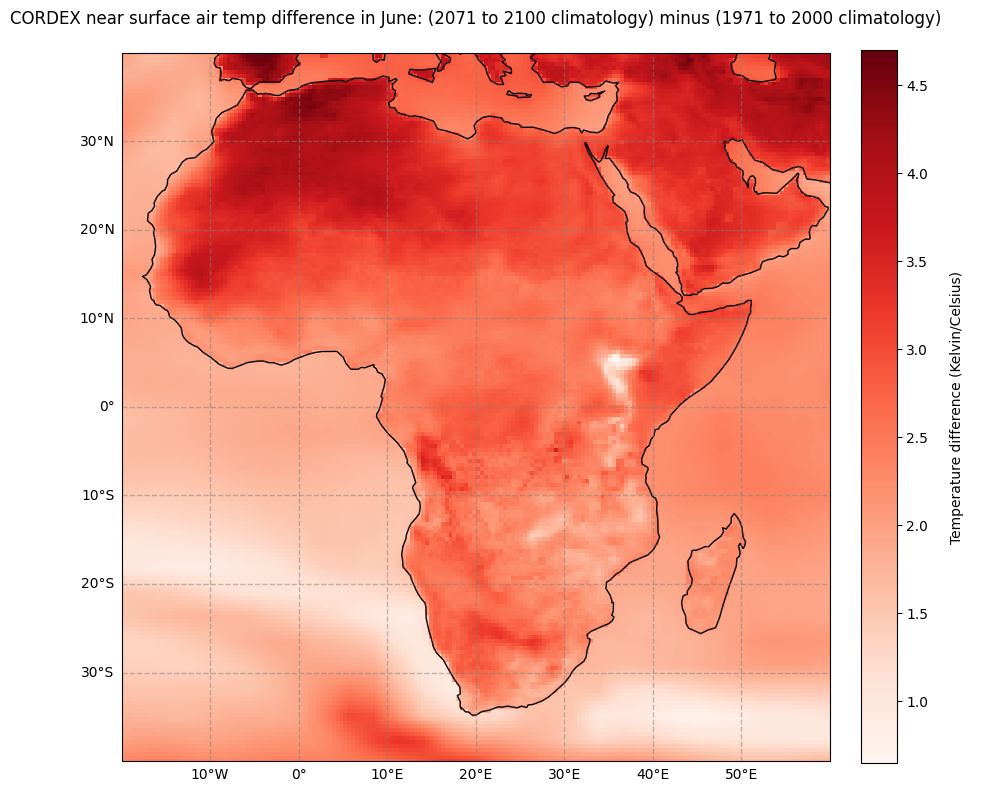

In [14]:
month = 5

# Initiate the plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plot the 2D map with pcolormesh
im = plt.pcolormesh(tas_difference_climatology.rlon, tas_difference_climatology.rlat,
                   tas_difference_climatology[month,:,:], cmap='Reds', transform=ccrs.PlateCarree())  # Change colormap to 'Reds'

# Add coast- and gridlines
ax.coastlines(color='black')
ax.set_extent([-20,60,-40,40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
ax.set_title('CORDEX near surface air temp difference in June: (2071 to 2100 climatology) minus (1971 to 2000 climatology)\n', fontsize=12)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\nTemperature difference (Kelvin/Celsius)\n')

# Save the figure
fig.savefig(f'{DATADIR}TAS_1971-2000_2071-2100_june.png', dpi=300)


As a last step, we repeat the visualization of climate change signal between the target (2071-2100) and reference (1971-2000) period. But this time, we create the average signal for the whole period, not only one month. For this, we have to compute the average over all months with the function `mean()`.

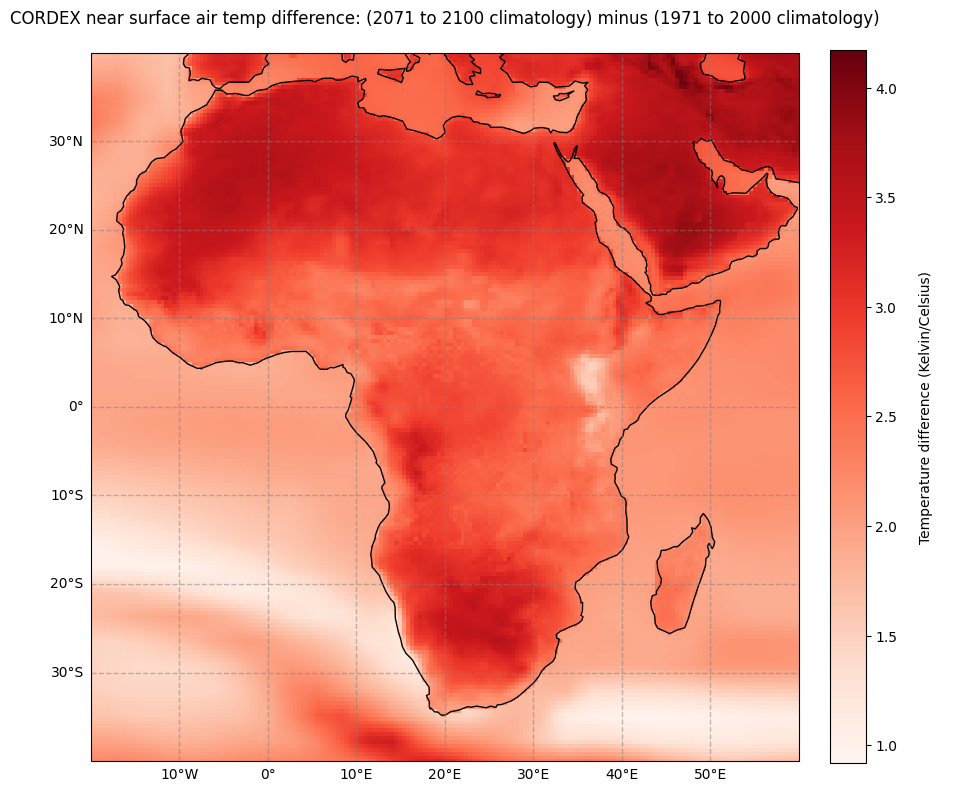

In [15]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = plt.pcolormesh(tas_difference_climatology.rlon, tas_difference_climatology.rlat,
                   tas_difference_climatology.mean('month'), cmap='Reds', transform=ccrs.PlateCarree())

ax.coastlines(color='black')
ax.set_extent([-20,60,-40,40], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('CORDEX near surface air temp difference: (2071 to 2100 climatology) minus (1971 to 2000 climatology)\n', fontsize=12)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\nTemperature difference (Kelvin/Celsius)\n')

fig.savefig(f'{DATADIR}TAS_1971-2000_2071-2100.png', dpi=300)

<hr>

## Key Messages to Take Home 📌

- Historical experiments cover the period where modern climate observations exist. They can be used as a reference period for comparison with scenario runs for the future.

- Scenario experiements are ensembles of climate projection experiments that provide different pathways of the future climate forcing.
  
- The "delta method" takes the difference between the future and past considering that the model biases are the same and can therefore be removed with the subtraction.

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>